In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('..')
sys.path.append('../lu')

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from utilities import setup, p_star_from_workers, p_star_from_workers_and_p_hat, p_star_from_workers_and_bounds
from utilities import total_variation, wasserstein, plot_embedding
from multiprocessing.pool import Pool
WA = r"$\textrm{W}_\mathcal{G}(\hat{\textbf{p}}_{\mathcal{H}(\mathcal{T})}, \textbf{p}^\star_{\mathcal{H}(\mathcal{T})})$"
TV = r"$\textrm{TV}(\hat{\textbf{p}}_{\mathcal{H}(\mathcal{T})}, \textbf{p}^\star_{\mathcal{H}(\mathcal{T})})$"
PHAT = r"$\hat{\textbf{p}}_{\mathcal{H}(\mathcal{T})}$"
PTRUE = r"$\textbf{p}^\star_{\mathcal{H}(\mathcal{T})}$"
label_size = 22 + 4
tick_size = 20 + 4
title_size = 24 + 4
legend_size = 20

In [2]:
df = pd.read_parquet("../dataset/zappos_6000.parquet")
df = df.set_index("worker_id")

1. bootstrap true distribution (for different fraction) (n_h = 5, 10)
2. hold 0.2 out 5 times, shuffle the rest multiple times to estimate p_hat (n_h = 5, 10)
3. hold 0.2 out 5 times, use the rest to get q_hat and get bounds (n_h = 5, 10)
4. varying n_h
    - total variation plot
    - wq
    - distribution plot

### Bootstrap True Distribution

In [3]:
def boostrap_p_star(prop, n_h, repeats):
    hyperplanes, regions, pairs, _, _ = setup(n_h, 0)
    with Pool(os.cpu_count() - 3) as p:
        results = p.starmap(p_star_from_workers, map(lambda i: (prop, df, hyperplanes, regions, pairs, i), range(repeats)))
    return pd.concat(results, axis="rows")

In [4]:
# hyperplanes, regions, pairs, L = setup(10, 0)
# p_stars_n_h_10_prop_01 = p_star_from_workers(0.996, df, hyperplanes, regions, pairs, 0)
# p_stars_n_h_10_prop_02 = p_star_from_workers(0.997, df, hyperplanes, regions, pairs, 0)
# p_stars_n_h_10_prop_03 = p_star_from_workers(0.998, df, hyperplanes, regions, pairs, 0)
# p_stars_n_h_10_prop_04 = p_star_from_workers(0.999, df, hyperplanes, regions, pairs, 0)
# p_stars_n_h_10_prop_05 = p_star_from_workers(1.000, df, hyperplanes, regions, pairs, 0)
p_stars_n_h_10_prop_01 = boostrap_p_star(0.1, 10, 100)
p_stars_n_h_10_prop_02 = boostrap_p_star(0.2, 10, 100)
p_stars_n_h_10_prop_03 = boostrap_p_star(0.3, 10, 100)
p_stars_n_h_10_prop_04 = boostrap_p_star(0.4, 10, 100)
p_stars_n_h_10_prop_05 = boostrap_p_star(0.5, 10, 100)
p_stars_n_h_5_prop_01 = boostrap_p_star(0.1, 5, 100)
p_stars_n_h_5_prop_02 = boostrap_p_star(0.2, 5, 100)
p_stars_n_h_5_prop_03 = boostrap_p_star(0.3, 5, 100)
p_stars_n_h_5_prop_04 = boostrap_p_star(0.4, 5, 100)
p_stars_n_h_5_prop_05 = boostrap_p_star(0.5, 5, 100)

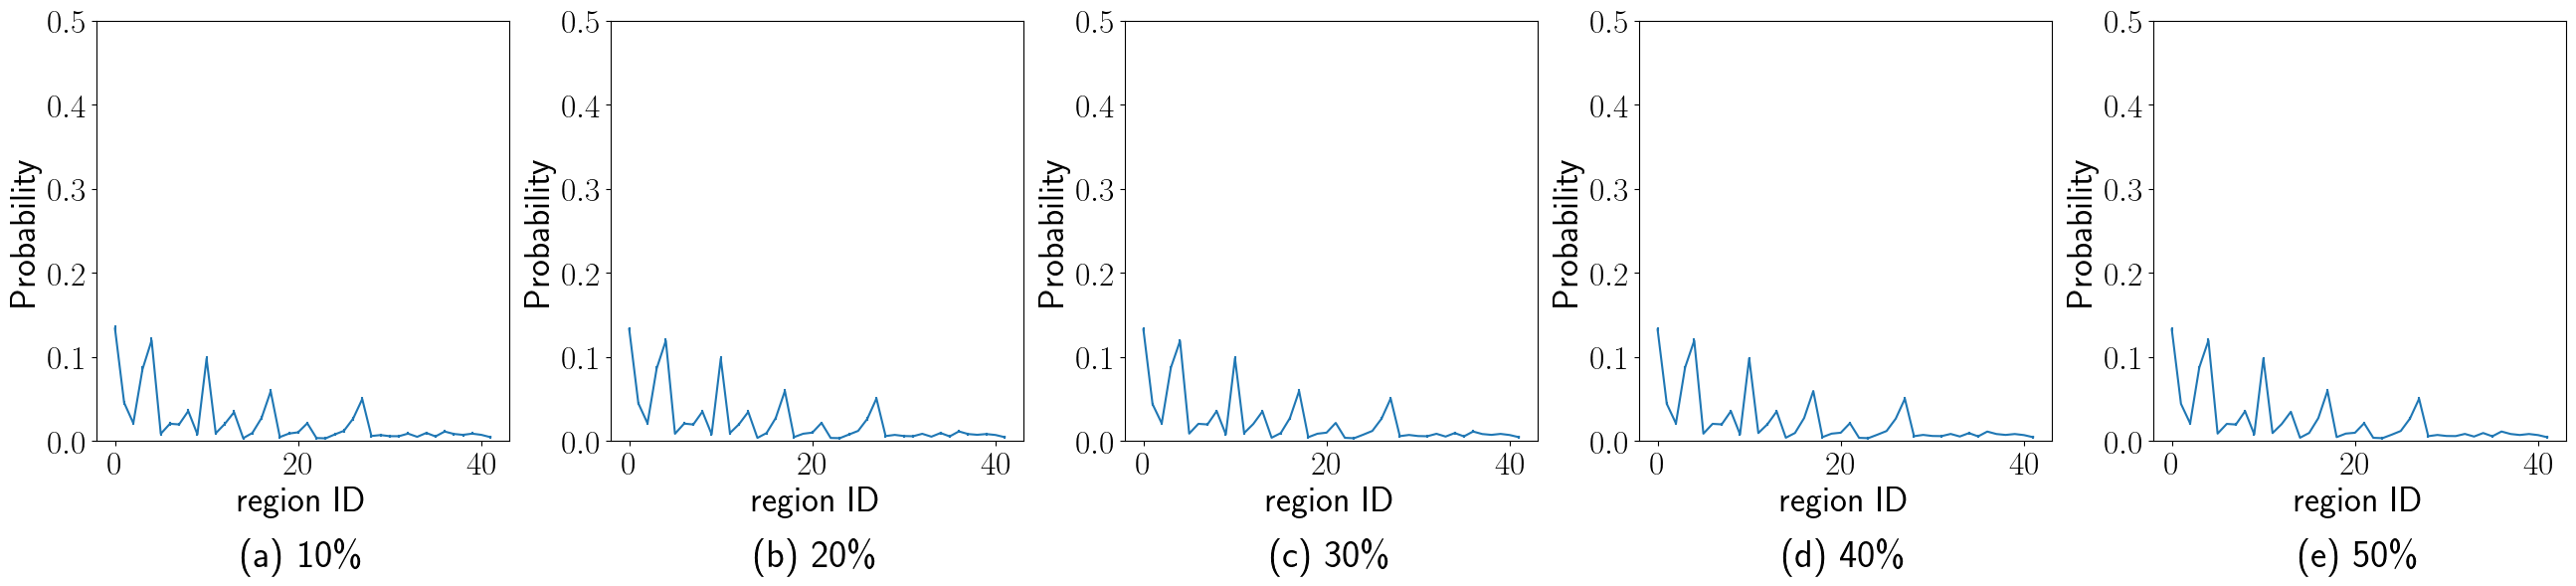

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(26, 6))
sns.lineplot(p_stars_n_h_10_prop_01, x="region ID", y="prob", ax=axs[0], err_style="bars")
sns.lineplot(p_stars_n_h_10_prop_02, x="region ID", y="prob", ax=axs[1], err_style="bars")
sns.lineplot(p_stars_n_h_10_prop_03, x="region ID", y="prob", ax=axs[2], err_style="bars")
sns.lineplot(p_stars_n_h_10_prop_04, x="region ID", y="prob", ax=axs[3], err_style="bars")
sns.lineplot(p_stars_n_h_10_prop_05, x="region ID", y="prob", ax=axs[4], err_style="bars")

titles = ["10\%",
          "20\%",
          "30\%",
          "40\%",
          "50\%",]
for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.set_ylabel("Probability", fontsize=label_size)
    ax.set_xlabel("region ID", fontsize=label_size)
    ax.set_ylim([0, 0.5])
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
    ax.set_title("(" + f"{chr(97 + i)}" + ") " + title, loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
# sns.lineplot(p_stars_n_h_10_prop_01, x="region ID", y="prob", ax=axs[5], label=r"10\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_02, x="region ID", y="prob", ax=axs[5], label=r"20\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_03, x="region ID", y="prob", ax=axs[5], label=r"30\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_04, x="region ID", y="prob", ax=axs[5], label=r"40\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_05, x="region ID", y="prob", ax=axs[5], label=r"50\%", err_style="bars")
# axs[5].set_title("10 hyperplanes")
# axs[5].set_ylim([0, 1])
fig.tight_layout()
plt.savefig("fig/zappos_pstar_bootstrap_n_h_10.pdf", dpi=600, format="pdf")

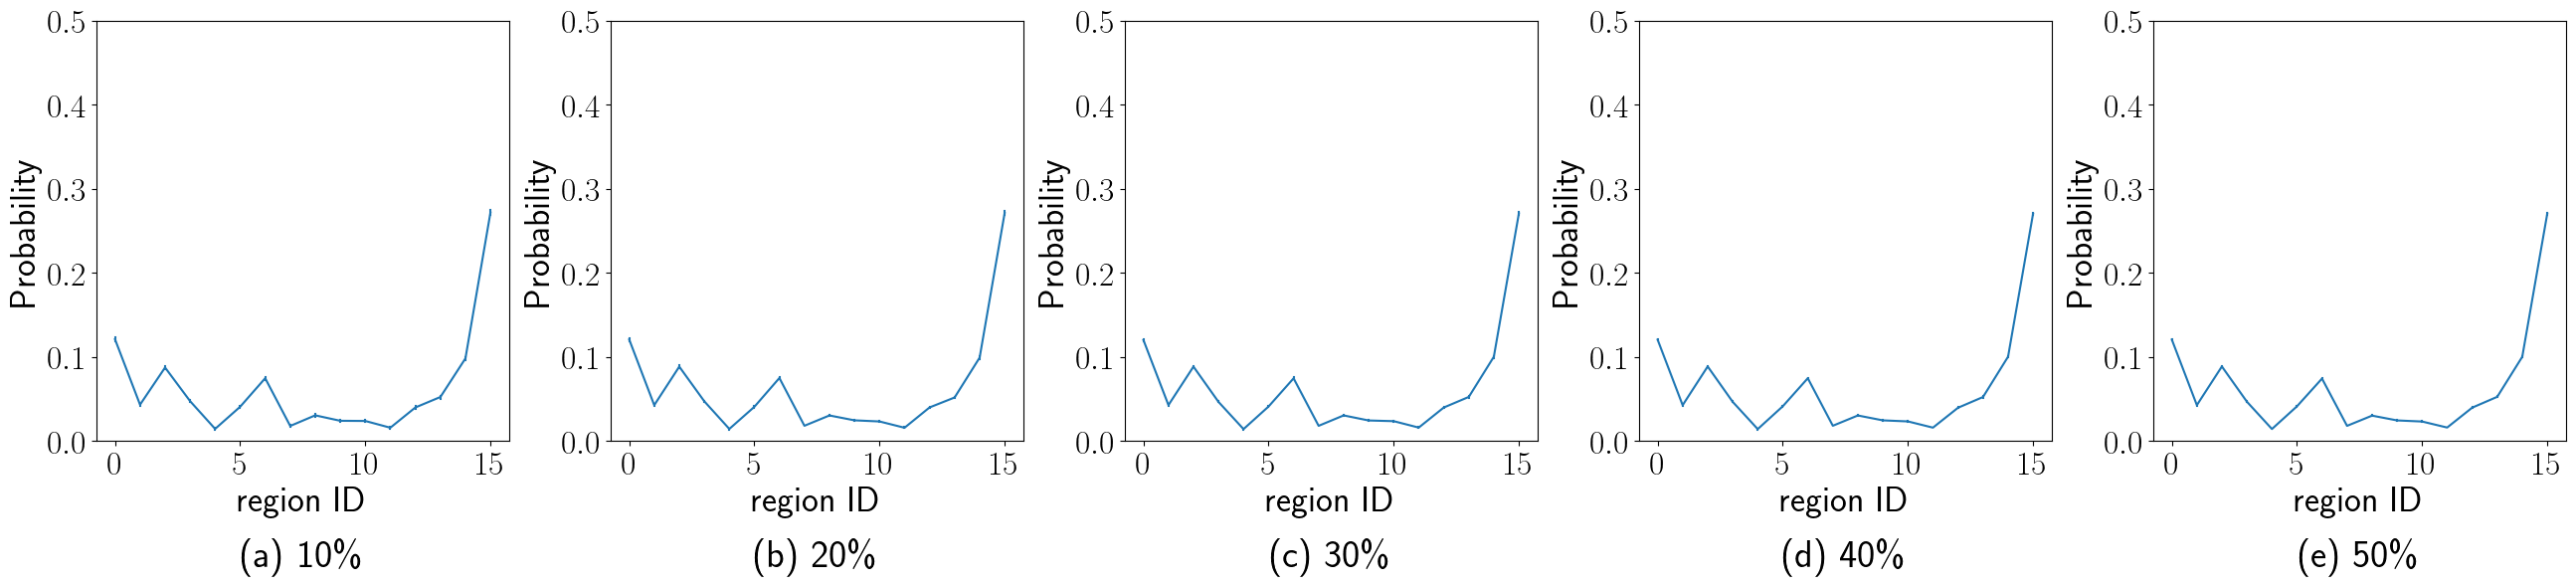

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(26, 6))
sns.lineplot(p_stars_n_h_5_prop_01, x="region ID", y="prob", ax=axs[0], err_style="bars")
sns.lineplot(p_stars_n_h_5_prop_02, x="region ID", y="prob", ax=axs[1], err_style="bars")
sns.lineplot(p_stars_n_h_5_prop_03, x="region ID", y="prob", ax=axs[2], err_style="bars")
sns.lineplot(p_stars_n_h_5_prop_04, x="region ID", y="prob", ax=axs[3], err_style="bars")
sns.lineplot(p_stars_n_h_5_prop_05, x="region ID", y="prob", ax=axs[4], err_style="bars")

titles = ["10\%",
          "20\%",
          "30\%",
          "40\%",
          "50\%",]
for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.set_ylabel("Probability", fontsize=label_size)
    ax.set_xlabel("region ID", fontsize=label_size)
    ax.set_ylim([0, 0.5])
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
    ax.set_title("(" + f"{chr(97 + i)}" + ") " + title, loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
# sns.lineplot(p_stars_n_h_10_prop_01, x="region ID", y="prob", ax=axs[5], label=r"10\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_02, x="region ID", y="prob", ax=axs[5], label=r"20\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_03, x="region ID", y="prob", ax=axs[5], label=r"30\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_04, x="region ID", y="prob", ax=axs[5], label=r"40\%", err_style="bars")
# sns.lineplot(p_stars_n_h_10_prop_05, x="region ID", y="prob", ax=axs[5], label=r"50\%", err_style="bars")
# axs[5].set_title("10 hyperplanes")
# axs[5].set_ylim([0, 1])
fig.tight_layout()
plt.savefig("fig/zappos_pstar_bootstrap_n_h_5.pdf", dpi=600, format="pdf")

/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


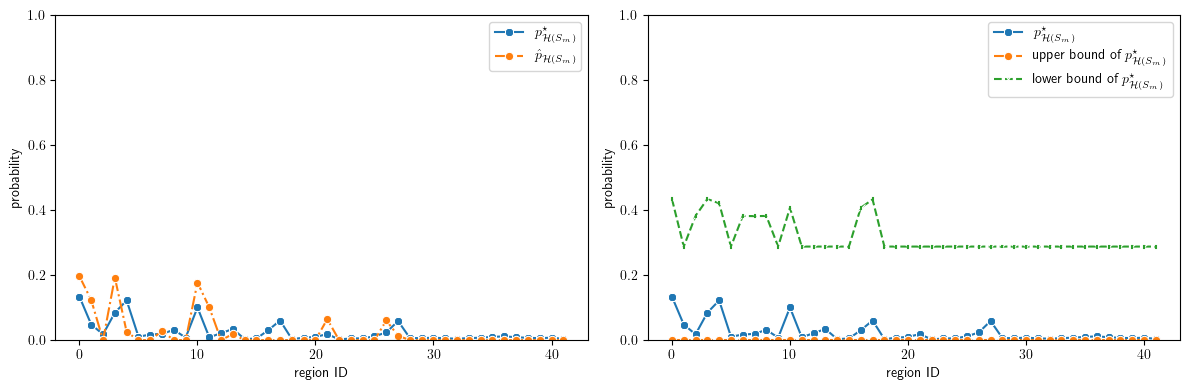

In [7]:
# plotting distribution and bounds
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
n_h = 10
hyperplanes, regions, pairs, M, L = setup(n_h, 0)
p_true, p_hat, _, _, _, _, _ = p_star_from_workers_and_p_hat(0.2, df, hyperplanes, regions, pairs, M, L, seed=0, method="least-square-graph", lamb=0.01)
p_star, p_lower, p_upper = p_star_from_workers_and_bounds(0.2, df, hyperplanes, regions, pairs, M, L, 0.1, n_h, 0)

sns.lineplot(p_true, x="region ID", y="prob", ax=axs[0], label=r"$p^\star_{\mathcal{H}(S_m)}$", marker='8', linestyle='-')
sns.lineplot(p_hat, x="region ID", y="prob", ax=axs[0], err_style="bars", label=r"$\hat{p}_{\mathcal{H}(S_m)}$", marker='o', linestyle='-.')
axs[0].set_ylim([0, 1])
axs[0].set_ylabel("probability")

sns.lineplot(p_star, x="region ID", y="prob", ax=axs[1], label=r"$p^\star_{\mathcal{H}(S_m)}$", marker='8', linestyle='-')
sns.lineplot(p_lower, x="region ID", y="prob", ax=axs[1], label=r"upper bound of $p^\star_{\mathcal{H}(S_m)}$", err_style="bars", marker='o', linestyle='-.')
sns.lineplot(p_upper, x="region ID", y="prob", ax=axs[1], label=r"lower bound of $p^\star_{\mathcal{H}(S_m)}$", err_style="bars", marker='x', linestyle='--')
axs[1].set_ylim([0, 1])
axs[1].set_ylabel("probability")

plt.legend()
plt.tight_layout()
fig.savefig(f"fig/zappos_figure.pdf", dpi=600, format="pdf", bbox_inches="tight")
plt.show()

## Estimate p hat

In [8]:
hyperplanes, regions, pairs, M, L = setup(10, 0)
results = [p_star_from_workers_and_p_hat(0.2, df, hyperplanes, regions, pairs, M, L, seed=i, method=method, lamb=0.01)
           for i in range(5)
           for method in ["least-square-graph", "least-square-l1", "least-square-l2", "kl"]]

In [9]:
markers = {
    "least-square-graph": "^",
    "least-square-l1": "o",
    "least-square-l2": "v",
    "kl": "4",
}

linestyles = {
    "least-square-graph": "-.",
    "least-square-l1": "--",
    "least-square-l2": ":",
    "kl": (0, (3, 5, 1, 5, 1, 5)),
}

colors = {
    "least-square-graph": "y",
    "least-square-l1": "g",
    "least-square-l2": "r",
    "kl": "m" 
}

/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1]

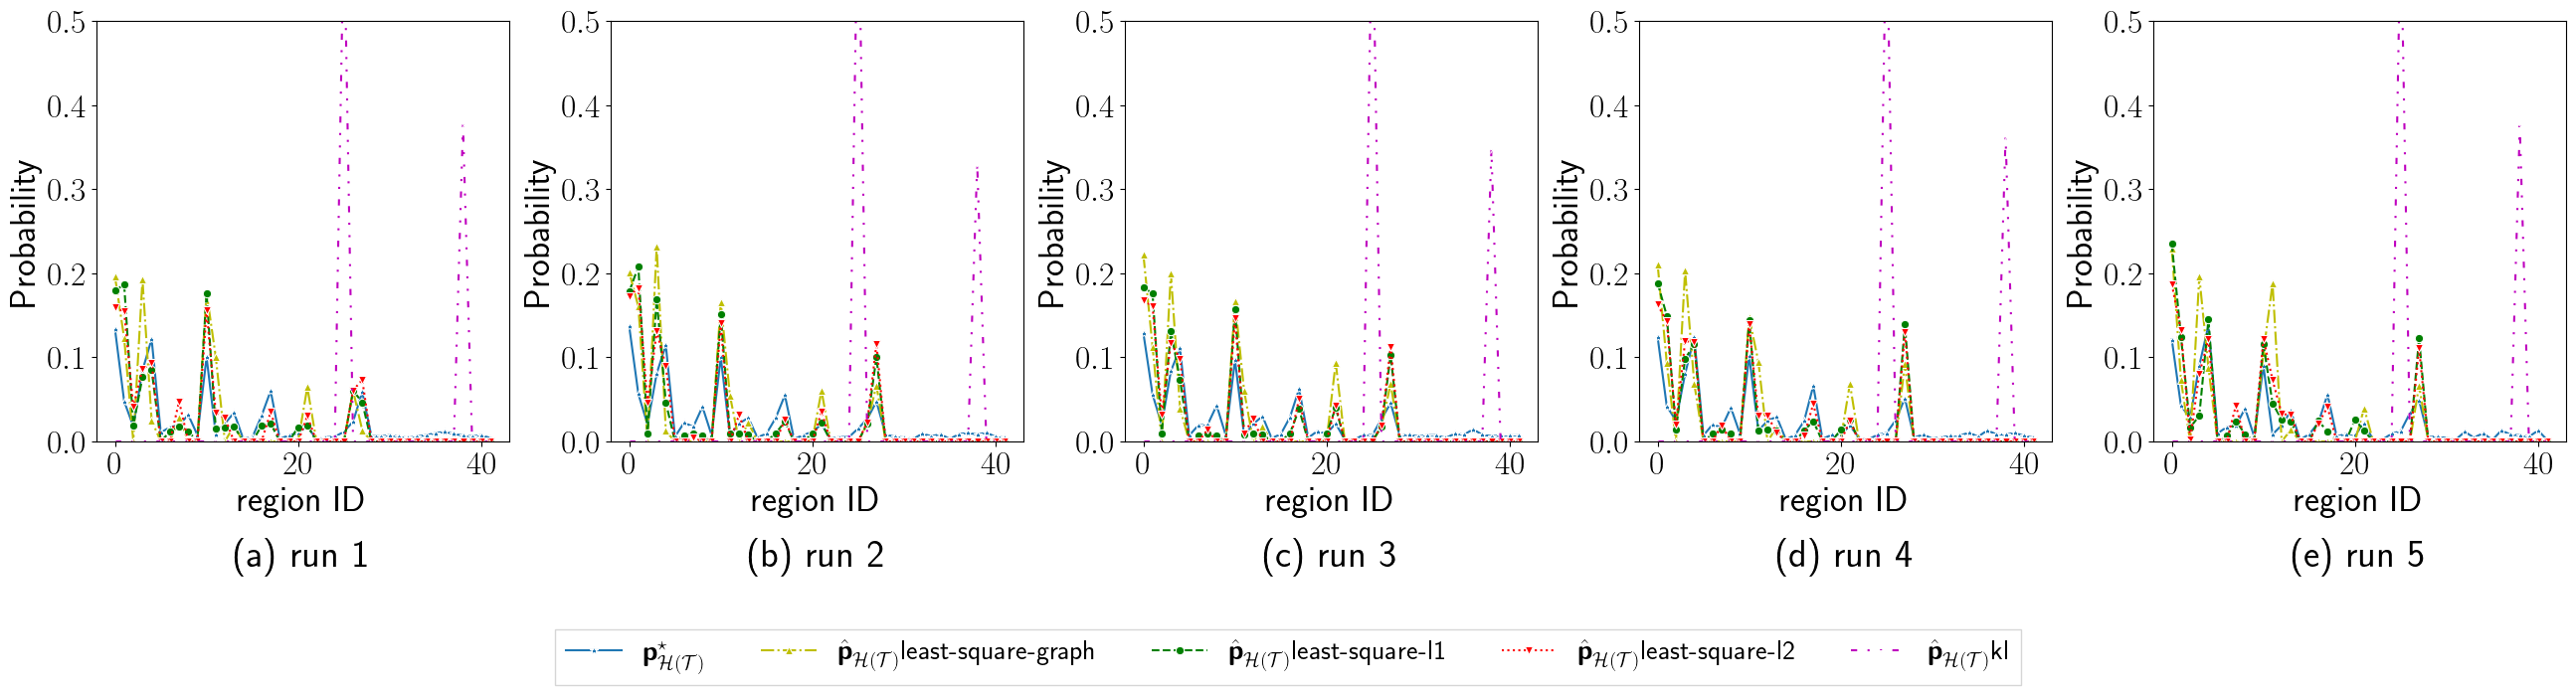

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(26, 6))
is_p_true_shown = defaultdict(bool)
for (p_true, p_hat, method, i, _, _, _) in results:
    if not is_p_true_shown[i]:
        sns.lineplot(p_true, x="region ID", y="prob", ax=axs[i], label=PTRUE, marker="*", linestyle="-")
        is_p_true_shown[i] = True

    sns.lineplot(p_hat, x="region ID", y="prob", ax=axs[i], err_style="bars", label=PHAT + method, marker=markers[method], linestyle=linestyles[method], color=colors[method])

    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].set_ylabel("Probability", fontsize=label_size)
    axs[i].legend(handles, labels, fancybox=False, shadow=False, fontsize=legend_size)
    axs[i].set_xlabel("region ID", fontsize=label_size)
    axs[i].set_title("(" + f"{chr(97 + i)}" + ") " + f"run {i + 1}", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
    axs[i].set_ylim([0, 0.5])
    axs[i].tick_params(axis='both', which='major', labelsize=tick_size)

handles, labels = axs[0].get_legend_handles_labels()
new_labels = list(map(lambda x: x, labels))

for i, ax in enumerate(axs):
    ax.get_legend().remove()

fig.legend(handles, new_labels, loc="outside lower center", bbox_to_anchor=(0.5, -0.18), fancybox=False, shadow=False, ncol=6, fontsize=legend_size)
fig.tight_layout()
plt.savefig("fig/zappos_pstar_phat_n_h_10.pdf", dpi=600, format="pdf")

In [11]:
hyperplanes, regions, pairs, M, L = setup(5, 0)
results = [p_star_from_workers_and_p_hat(0.2, df, hyperplanes, regions, pairs, M, L, seed=i, method=method, lamb=0.01)
           for i in range(5)
           for method in ["least-square-graph", "least-square-l1", "least-square-l2", "kl"]]

/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1]

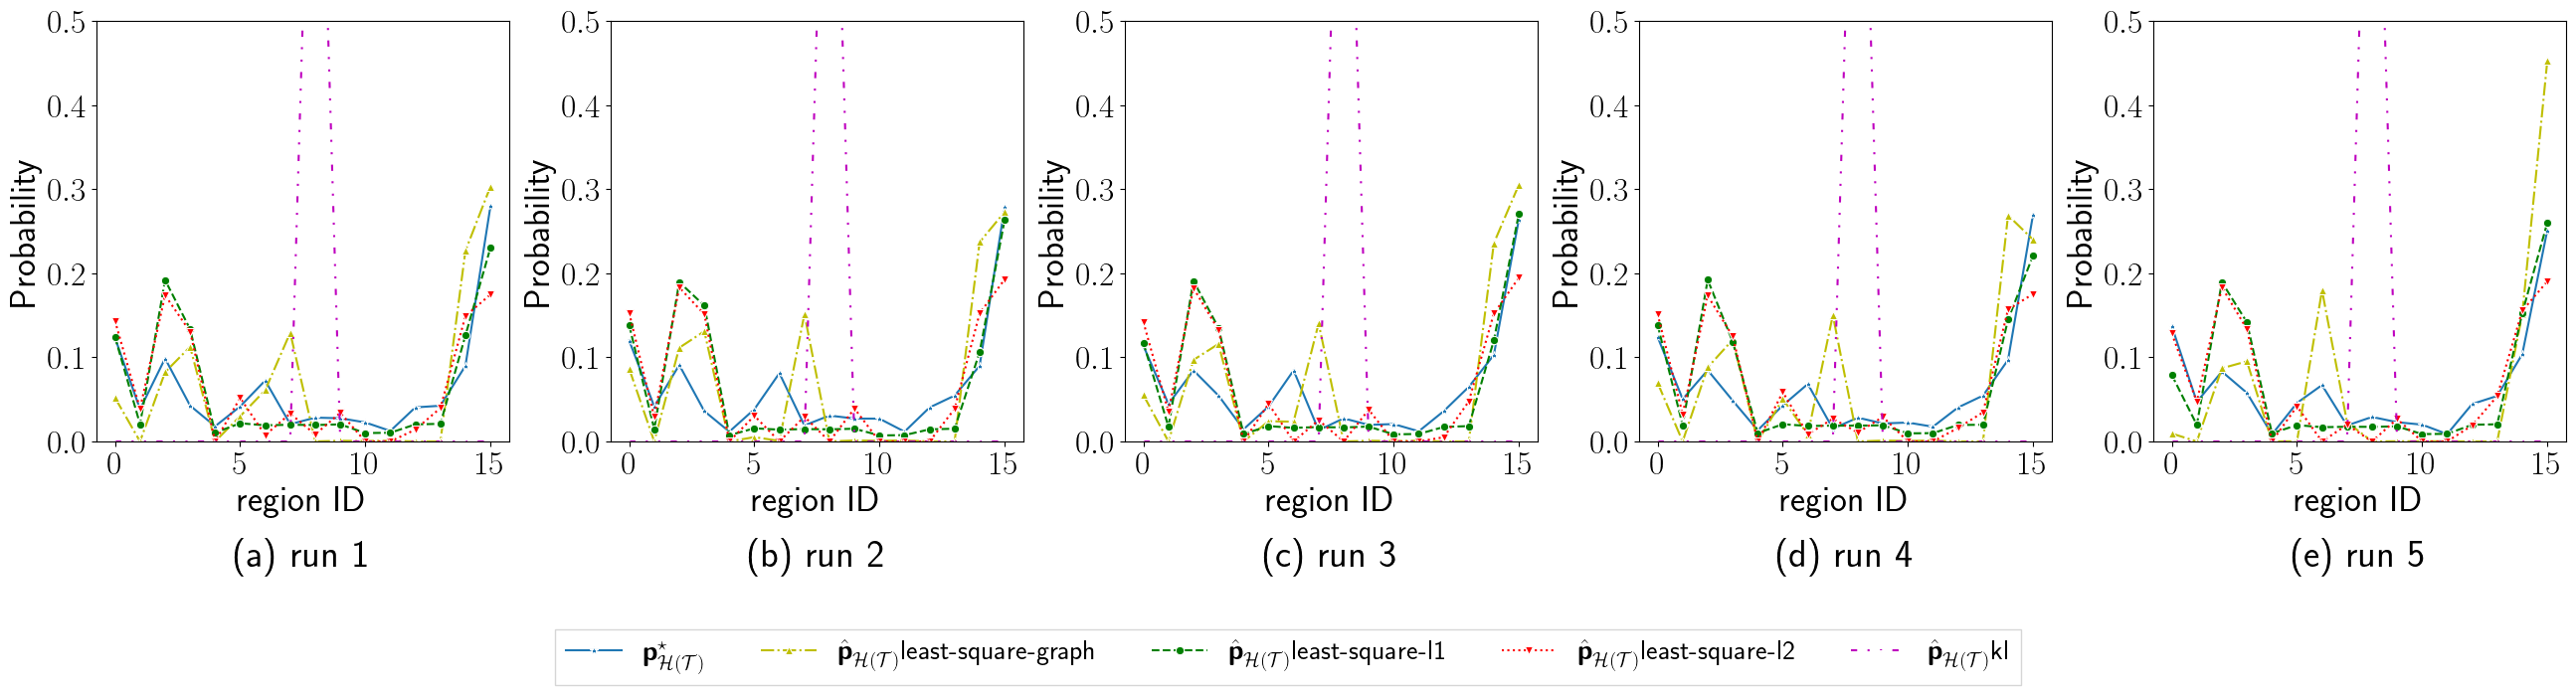

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(26, 6))

is_p_true_shown = defaultdict(bool)
for (p_true, p_hat, method, i, _, _, _) in results:
    if not is_p_true_shown[i]:
        sns.lineplot(p_true, x="region ID", y="prob", ax=axs[i], label=PTRUE, marker="*", linestyle="-")
        is_p_true_shown[i] = True

    sns.lineplot(p_hat, x="region ID", y="prob", ax=axs[i], err_style="bars", label=PHAT + method, marker=markers[method], linestyle=linestyles[method], color=colors[method])

    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].set_ylabel("Probability", fontsize=label_size)
    axs[i].legend(handles, labels, fancybox=False, shadow=False, fontsize=legend_size)
    axs[i].set_xlabel("region ID", fontsize=label_size)
    axs[i].set_title("(" + f"{chr(97 + i)}" + ") " + f"run {i + 1}", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
    axs[i].set_ylim([0, 0.5])
    axs[i].tick_params(axis='both', which='major', labelsize=tick_size)

handles, labels = axs[0].get_legend_handles_labels()
new_labels = list(map(lambda x: x, labels))

for i, ax in enumerate(axs):
    ax.get_legend().remove()

fig.legend(handles, new_labels, loc="outside lower center", bbox_to_anchor=(0.5, -0.18), fancybox=False, shadow=False, ncol=6, fontsize=legend_size)
fig.tight_layout()
plt.savefig("fig/zappos_pstar_phat_n_h_5.pdf", dpi=600, format="pdf")

/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1]

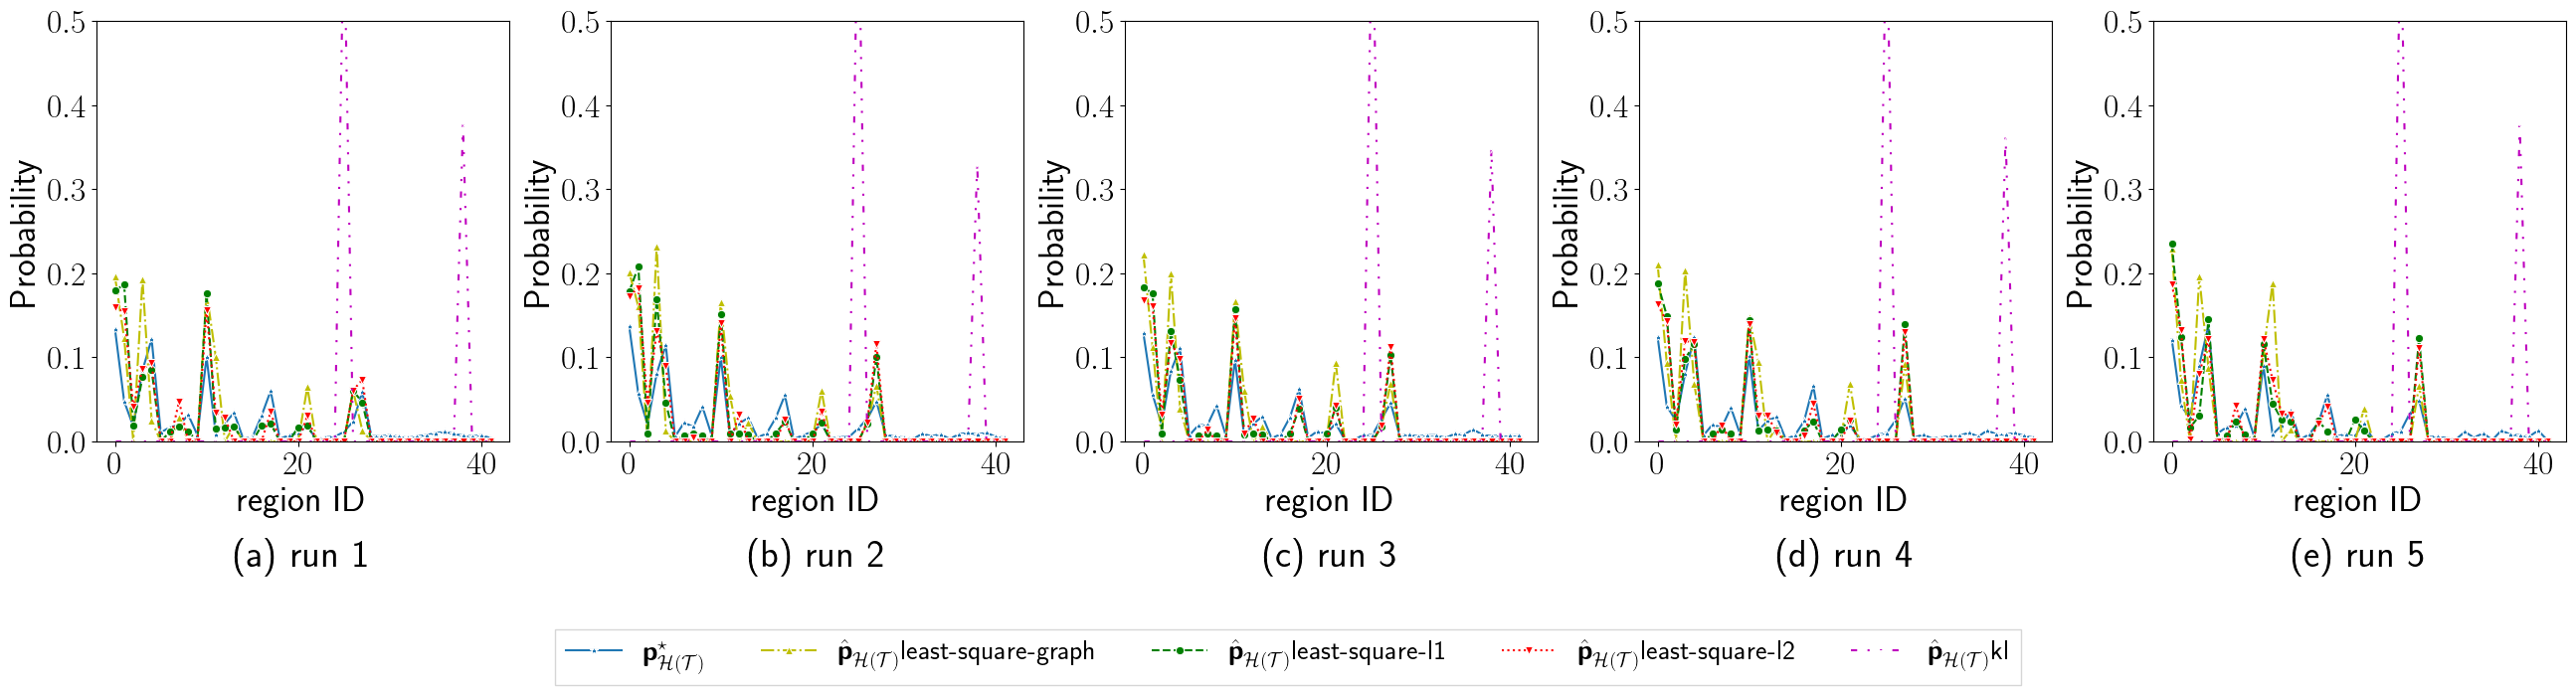

In [13]:
hyperplanes, regions, pairs, M, L = setup(10, 0)
results = [p_star_from_workers_and_p_hat(0.2, df, hyperplanes, regions, pairs, M, L, seed=i, method=method, lamb=0.01)
           for i in range(5)
           for method in ["least-square-graph", "least-square-l1", "least-square-l2", "kl"]]

fig, axs = plt.subplots(1, 5, figsize=(26, 6))

is_p_true_shown = defaultdict(bool)
for (p_true, p_hat, method, i, _, _, _) in results:
    if not is_p_true_shown[i]:
        sns.lineplot(p_true, x="region ID", y="prob", ax=axs[i], label=PTRUE, marker="*", linestyle="-")
        is_p_true_shown[i] = True

    sns.lineplot(p_hat, x="region ID", y="prob", ax=axs[i], err_style="bars", label=PHAT + method, marker=markers[method], linestyle=linestyles[method], color=colors[method])

    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].set_ylabel("Probability", fontsize=label_size)
    axs[i].legend(handles, labels, fancybox=False, shadow=False, fontsize=legend_size)
    axs[i].set_xlabel("region ID", fontsize=label_size)
    axs[i].set_title("(" + f"{chr(97 + i)}" + ") " + f"run {i + 1}", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
    axs[i].set_ylim([0, 0.5])
    axs[i].tick_params(axis='both', which='major', labelsize=tick_size)

handles, labels = axs[0].get_legend_handles_labels()
new_labels = list(map(lambda x: x, labels))

for i, ax in enumerate(axs):
    ax.get_legend().remove()

fig.legend(handles, new_labels, loc="outside lower center", bbox_to_anchor=(0.5, -0.18), fancybox=False, shadow=False, ncol=6, fontsize=legend_size)
fig.tight_layout()
plt.savefig("fig/zappos_pstar_phat_n_h_5.pdf", dpi=600, format="pdf")

In [14]:
n_h = 10
hyperplanes, regions, pairs, M, L = setup(n_h, 0)
results = [p_star_from_workers_and_bounds(0.2, df, hyperplanes, regions, pairs, M, L, 0.1, n_h, i) for i in range(5)]

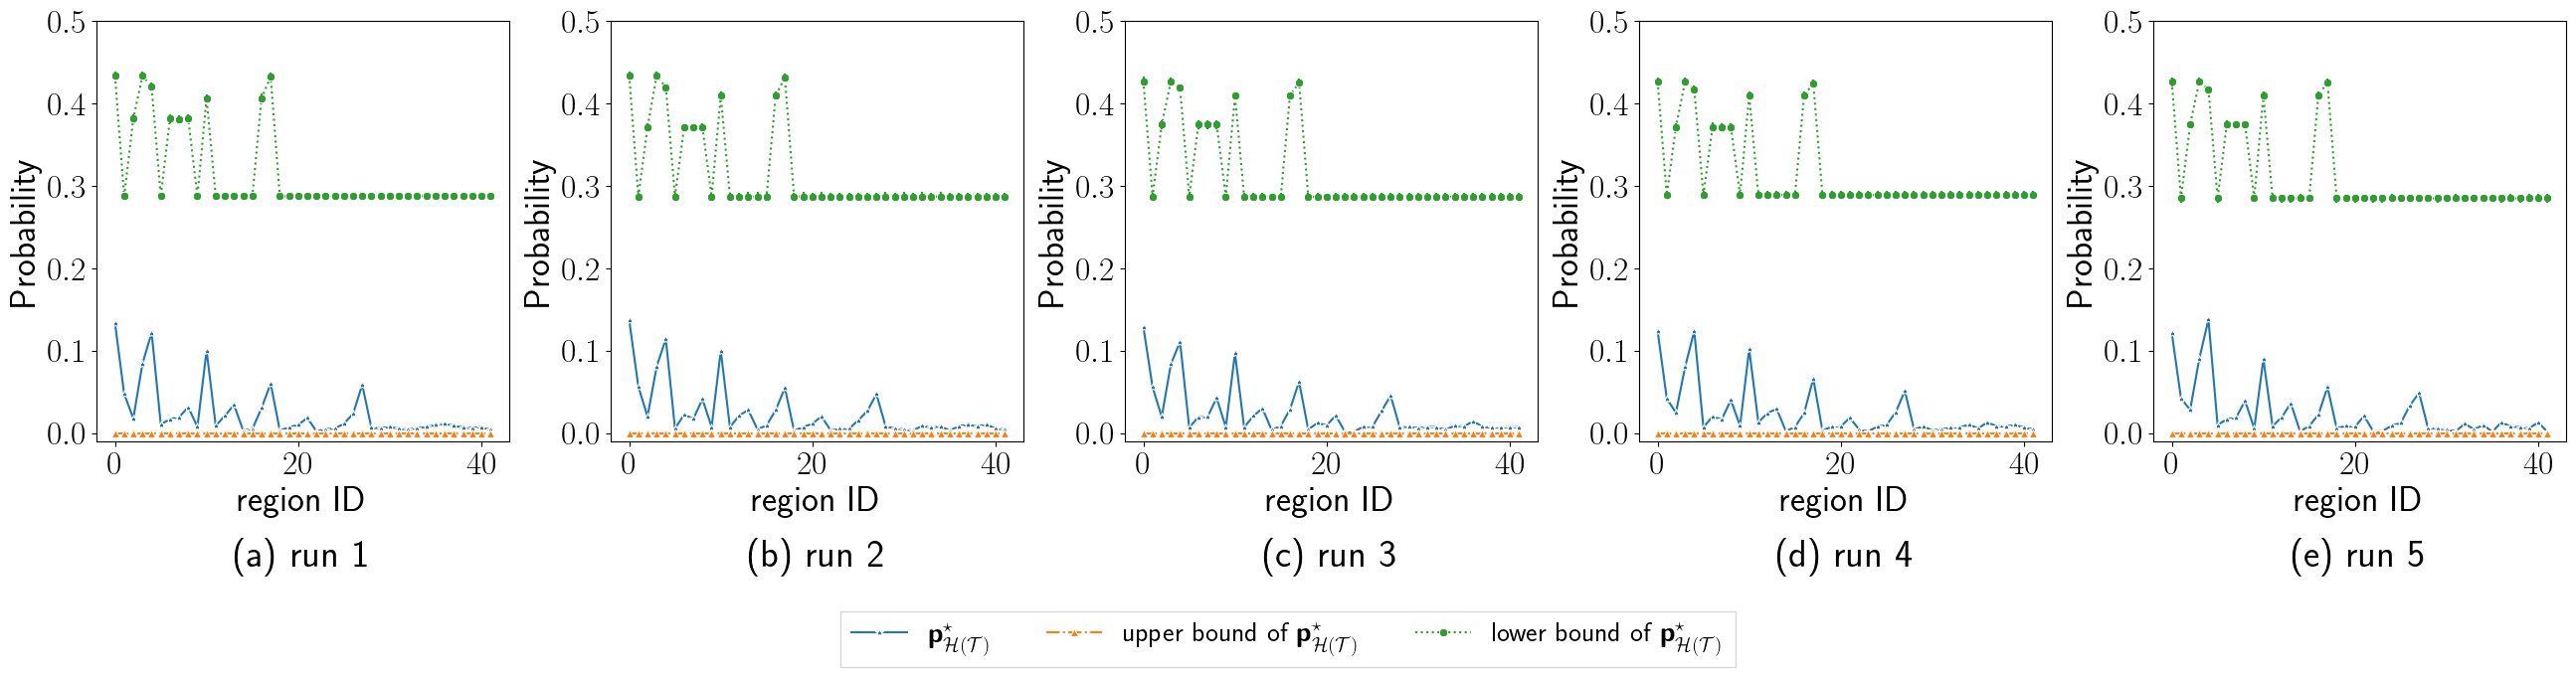

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(26, 6))
for i, (p_true, p_lower, p_upper) in enumerate(results):
    sns.lineplot(p_true, x="region ID", y="prob", ax=axs[i], label=PTRUE, marker="*", linestyle="-")
    sns.lineplot(p_lower, x="region ID", y="prob", ax=axs[i], label="upper bound of " + PTRUE, err_style="bars", marker="^", linestyle="-.")
    sns.lineplot(p_upper, x="region ID", y="prob", ax=axs[i], label="lower bound of " + PTRUE, err_style="bars", marker="8", linestyle=":")
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].set_ylabel("Probability", fontsize=label_size)
    axs[i].legend(handles, labels, fancybox=False, shadow=False, fontsize=legend_size)
    axs[i].get_legend().remove()
    axs[i].set_xlabel("region ID", fontsize=label_size)
    axs[i].set_title("(" + f"{chr(97 + i)}" + ") " + f"run {i + 1}", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
    axs[i].set_ylim([-0.01, 0.5])
    axs[i].tick_params(axis='both', which='major', labelsize=tick_size)

fig.tight_layout()
fig.legend(handles, labels, loc="outside lower center", bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=6, fontsize=legend_size)
plt.savefig("fig/zappos_pstar_bounds_n_h_10.pdf", dpi=600, format="pdf")

In [16]:
n_h = 5
hyperplanes, regions, pairs, M, L = setup(n_h, 0)
results = [p_star_from_workers_and_bounds(0.2, df, hyperplanes, regions, pairs, M, L, 0.1, n_h, i) for i in range(5)]

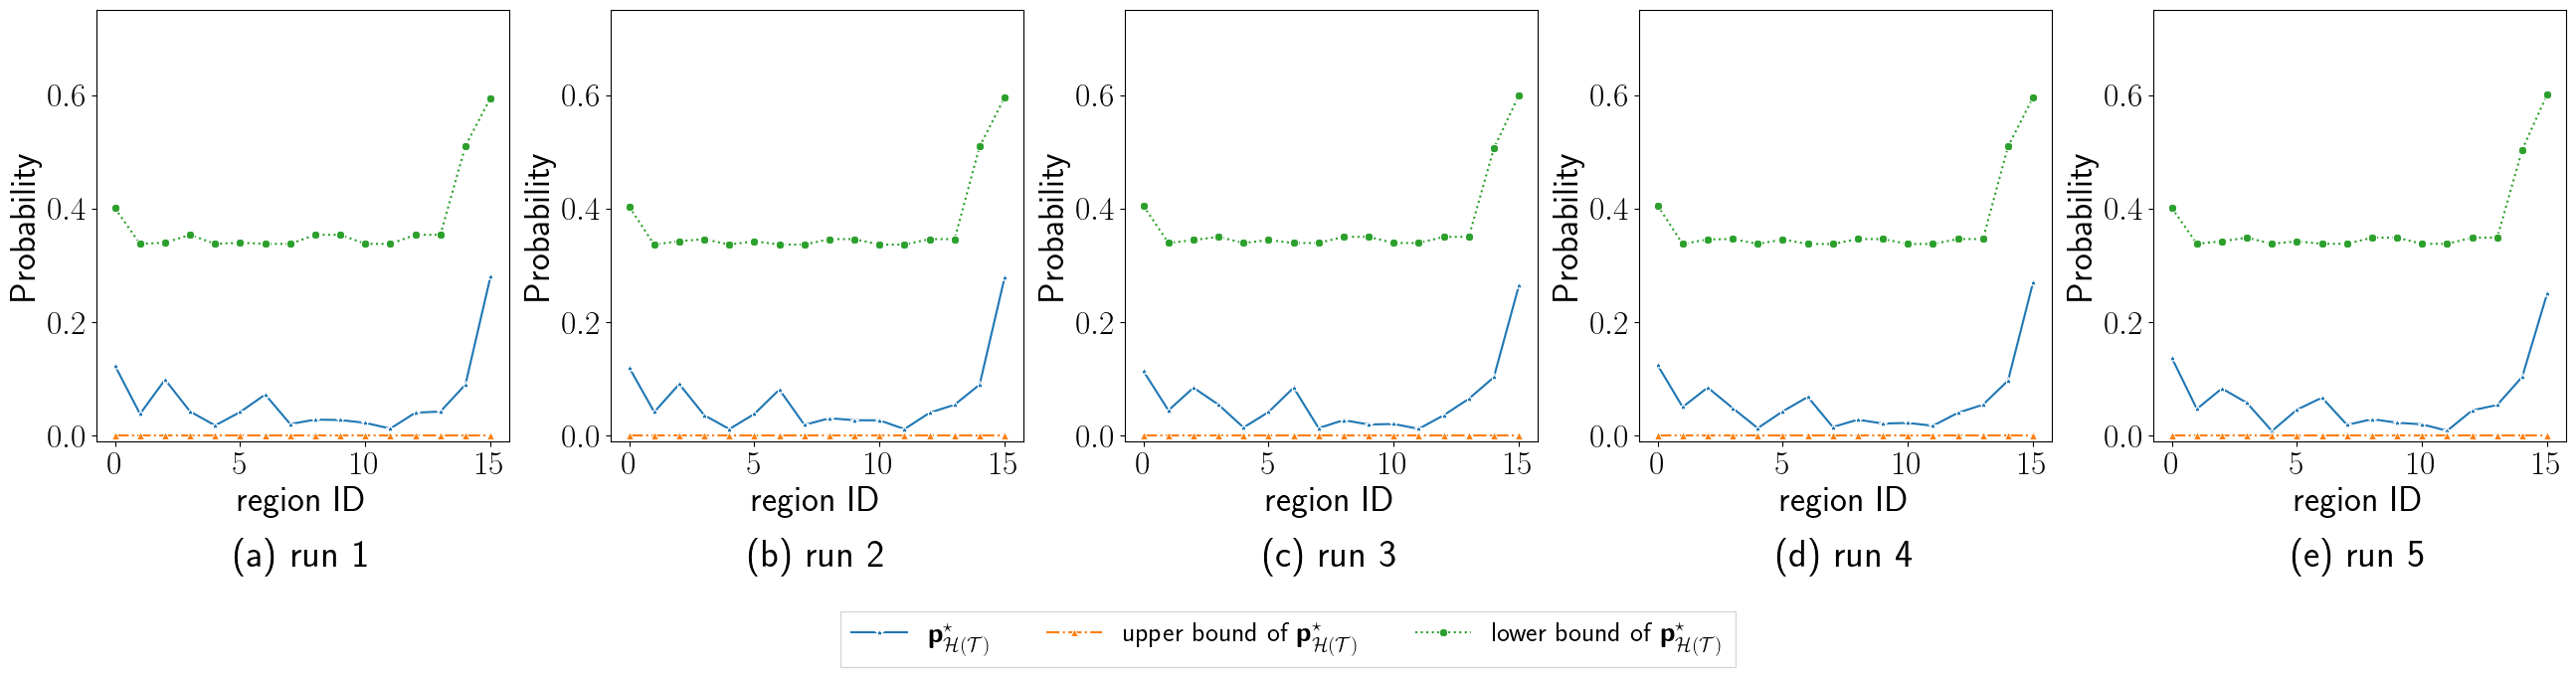

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(26, 6))
for i, (p_true, p_lower, p_upper) in enumerate(results):
    sns.lineplot(p_true, x="region ID", y="prob", ax=axs[i], label=PTRUE, marker="*", linestyle="-")
    sns.lineplot(p_lower, x="region ID", y="prob", ax=axs[i], label="upper bound of " + PTRUE, err_style="bars", marker="^", linestyle="-.")
    sns.lineplot(p_upper, x="region ID", y="prob", ax=axs[i], label="lower bound of " + PTRUE, err_style="bars", marker="8", linestyle=":")
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].set_ylabel("Probability", fontsize=label_size)
    axs[i].legend(handles, labels, fancybox=False, shadow=False, fontsize=legend_size)
    axs[i].get_legend().remove()
    axs[i].set_xlabel("region ID", fontsize=label_size)
    axs[i].set_title("(" + f"{chr(97 + i)}" + ") " + f"run {i + 1}", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
    axs[i].set_ylim([-0.01, 0.75])
    axs[i].tick_params(axis='both', which='major', labelsize=tick_size)

fig.tight_layout()
fig.legend(handles, labels, loc="outside lower center", bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=6, fontsize=legend_size)
plt.savefig("fig/zappos_pstar_bounds_n_h_5.pdf", dpi=600, format="pdf")

## Varying $n_h$

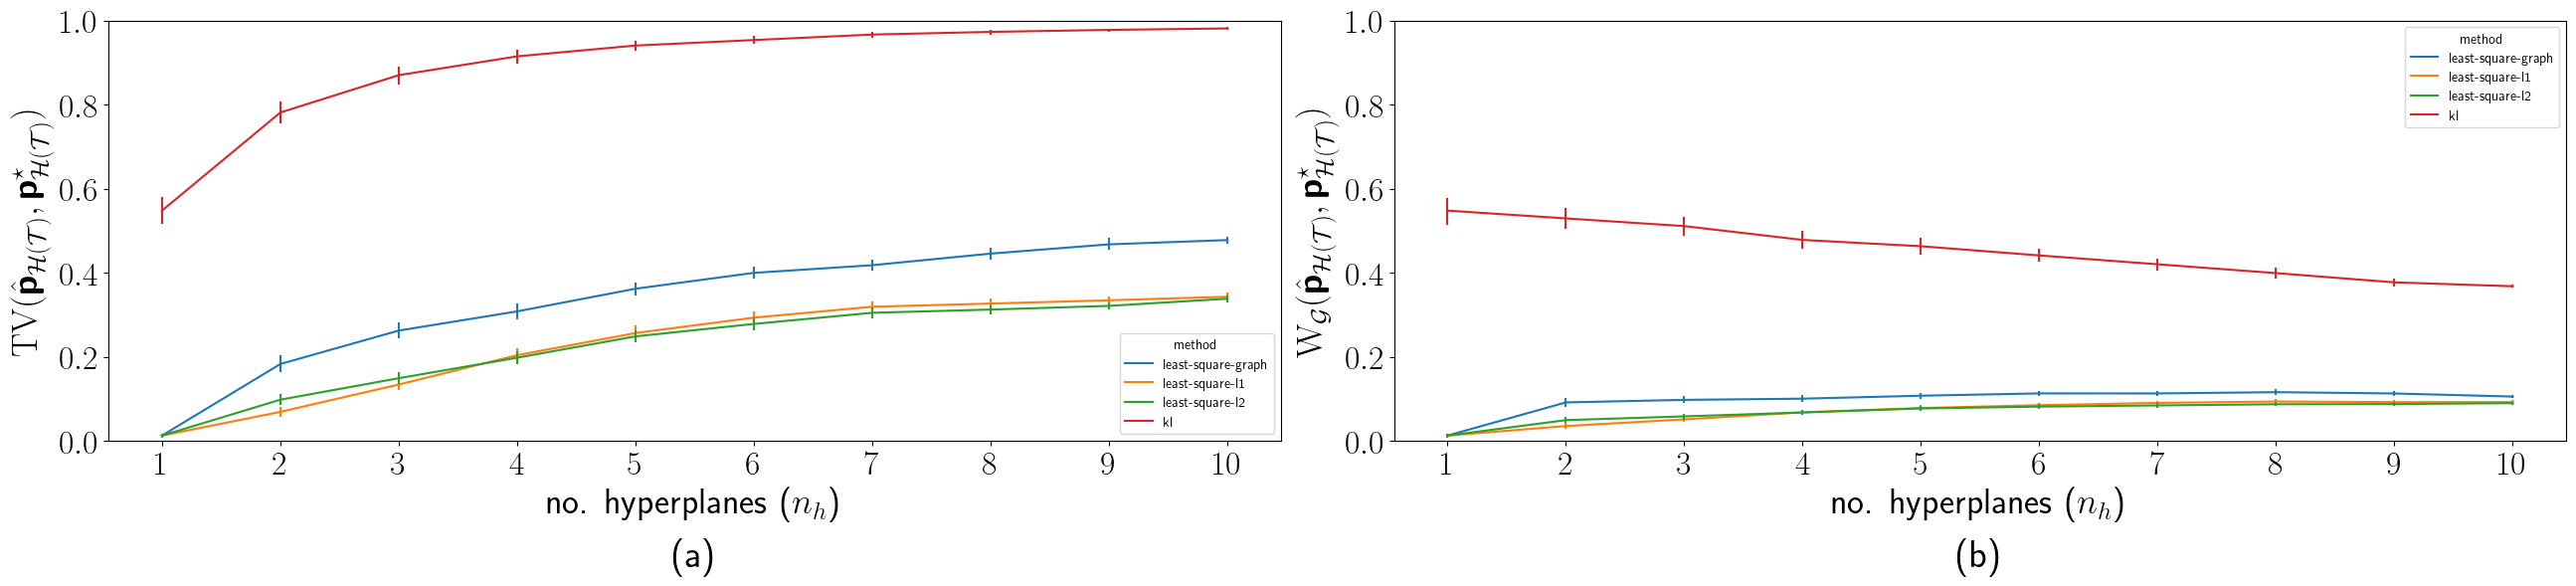

In [18]:
err_df = pd.read_parquet("varying_n_h_err.parquet")

fig, axs = plt.subplots(1, 2, figsize=(26, 6))
sns.lineplot(pd.DataFrame(err_df), x="n_h", y="TV", ax=axs[0], err_style="bars", hue='method')
sns.lineplot(pd.DataFrame(err_df), x="n_h", y="WA", ax=axs[1], err_style="bars", hue='method')

axs[0].set_ylabel(TV, fontsize=label_size)
axs[1].set_ylabel(WA, fontsize=label_size)

for i, ax in enumerate(axs):
    ax.set_xlabel(r"no. hyperplanes ($n_h$)", fontsize=label_size)
    ax.set_xticks(list(range(1, 11)))
    ax.set_title("(" + f"{chr(97 + i)}" + ")", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")
    ax.set_ylim([0, 1])
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
fig.tight_layout()
plt.savefig("fig/zappos_varying_n_h_tv_wa.pdf", dpi=600, format="pdf")

In [3]:
results = []
regions_s = []
for n_h in range(1, 11):
    hyperplanes, regions, pairs, M, L = setup(n_h, 0)
    result = p_star_from_workers_and_p_hat(0.2, df, hyperplanes, regions, pairs, M, L, 0, method='least-square-graph', lamb=0.01)
    results.append(result)
    regions_s.append(regions)

/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/var/folders/0b/gtjn2bqj7hl7mth2hd2ybr700000gn/T/ipykernel_7574/3186234617.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/yichen/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/var/folders/0b/gtjn2bqj7hl7mth2hd2ybr700000gn/T/ipykernel_7574/3186234617.py:25: UserWarning: M

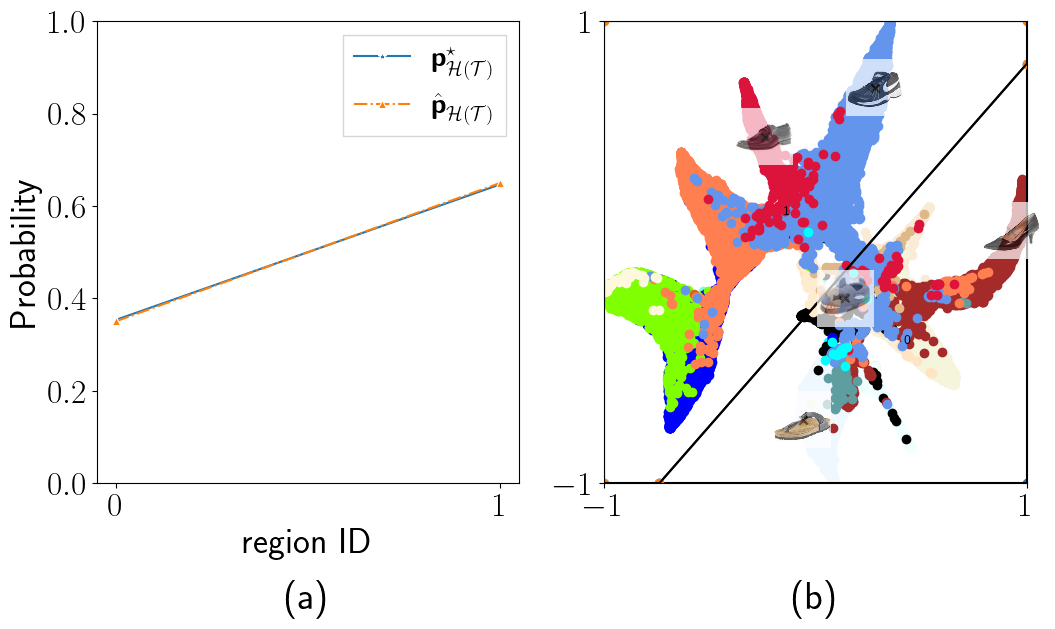

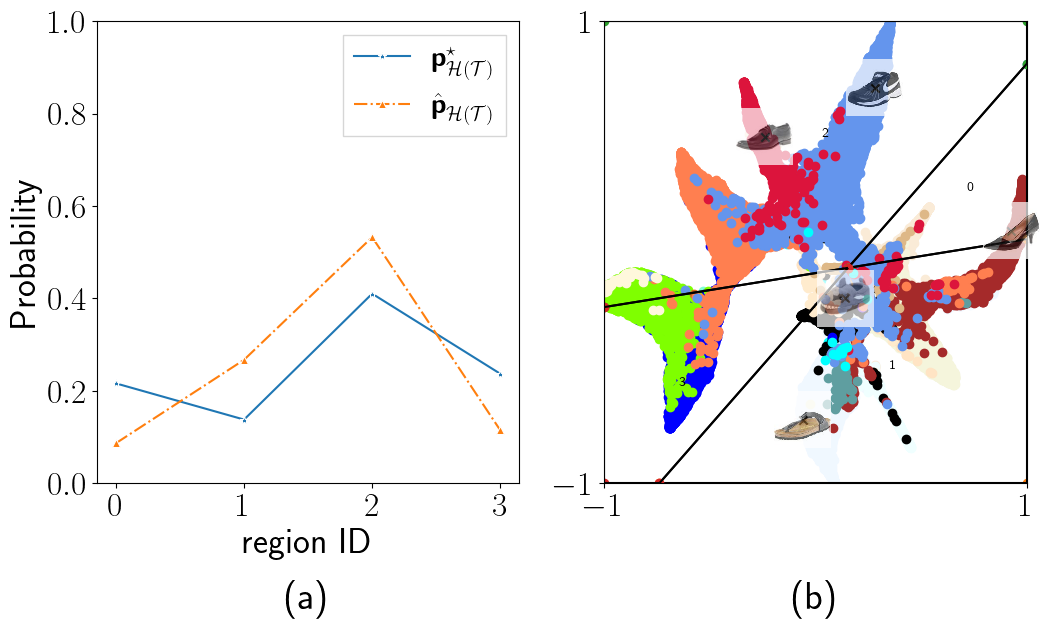

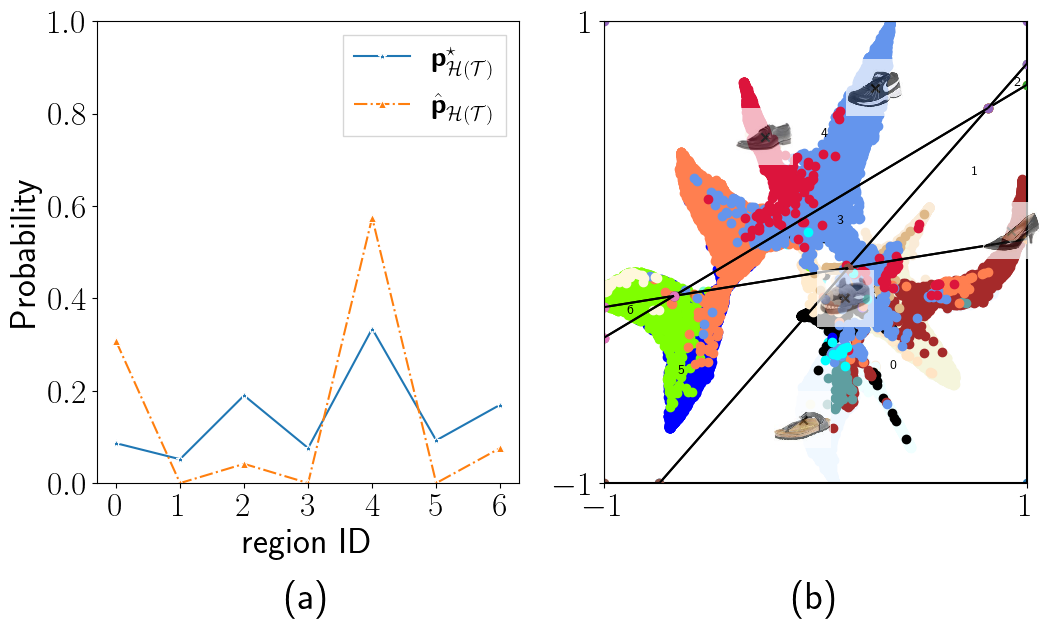

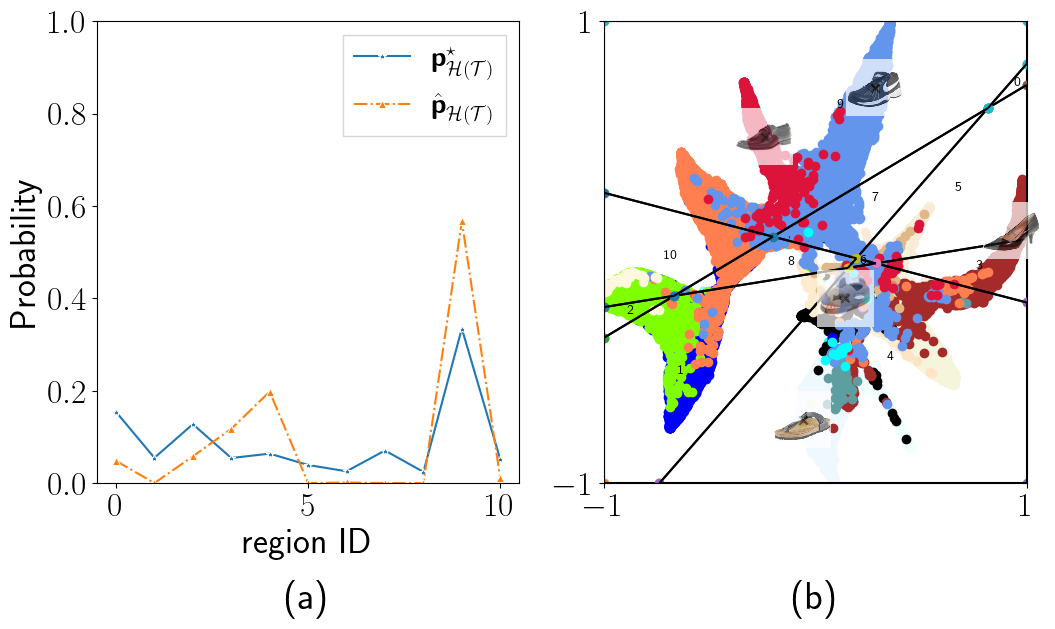

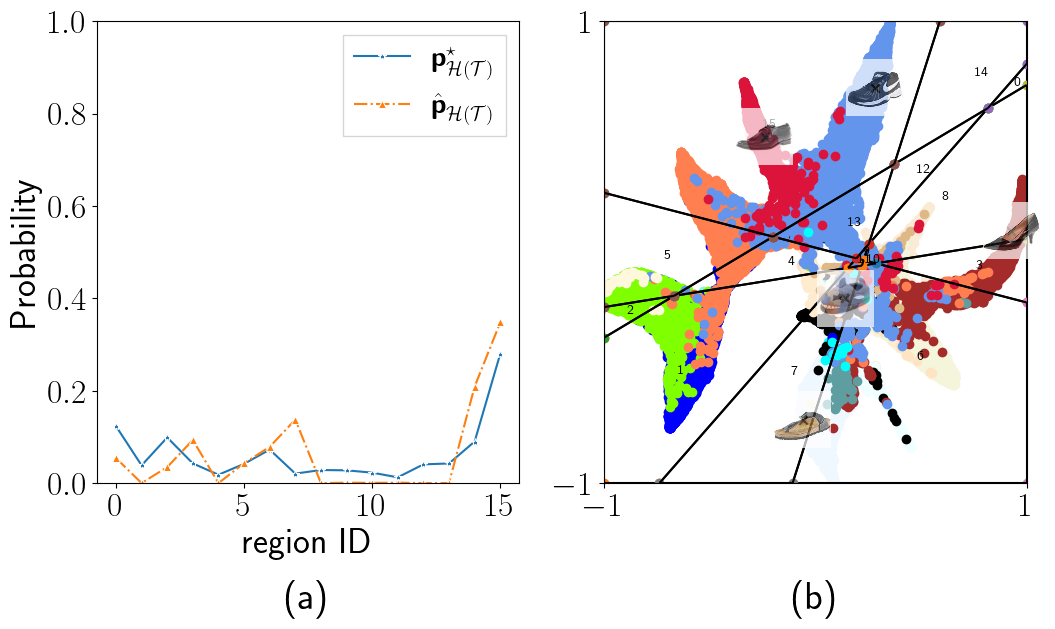

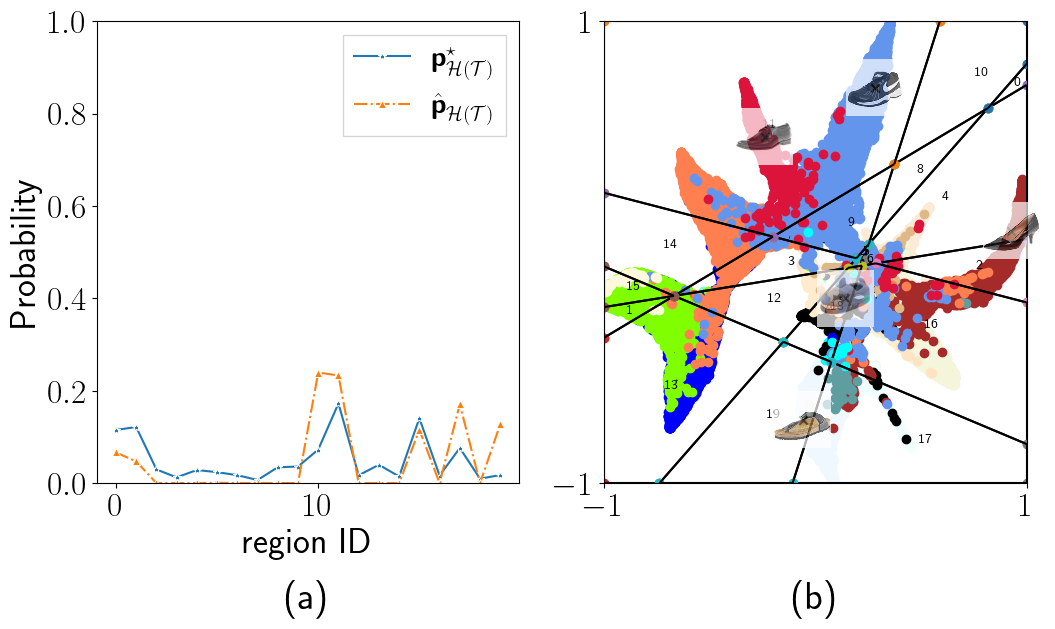

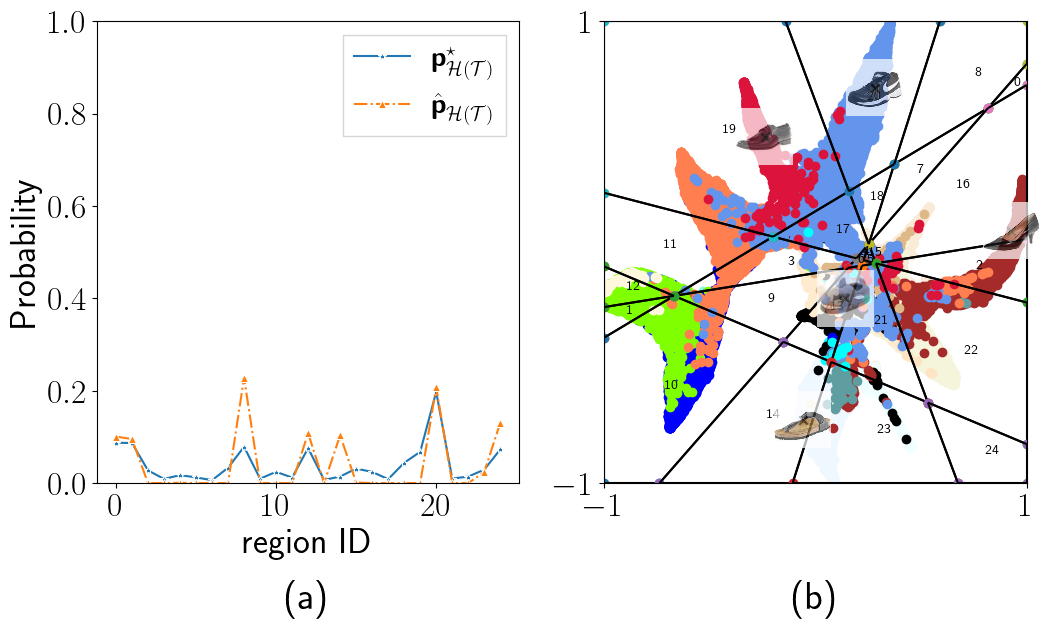

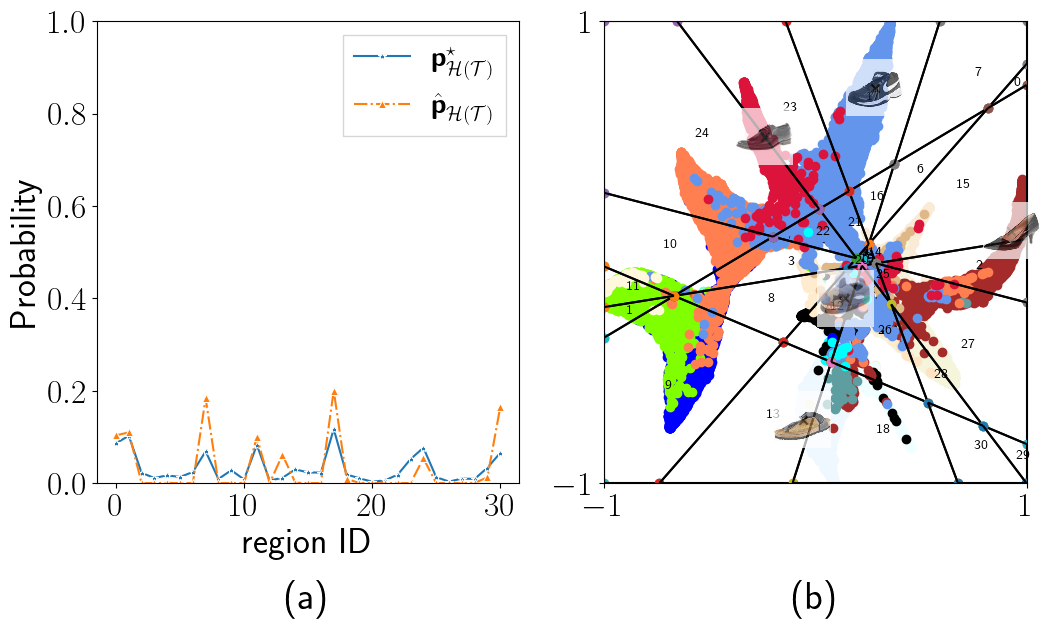

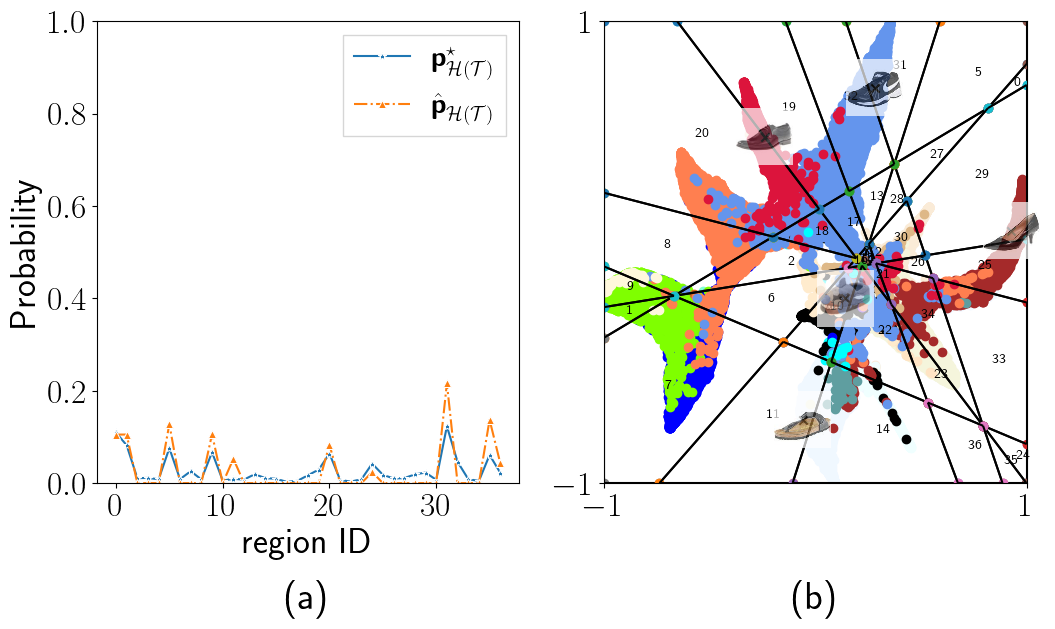

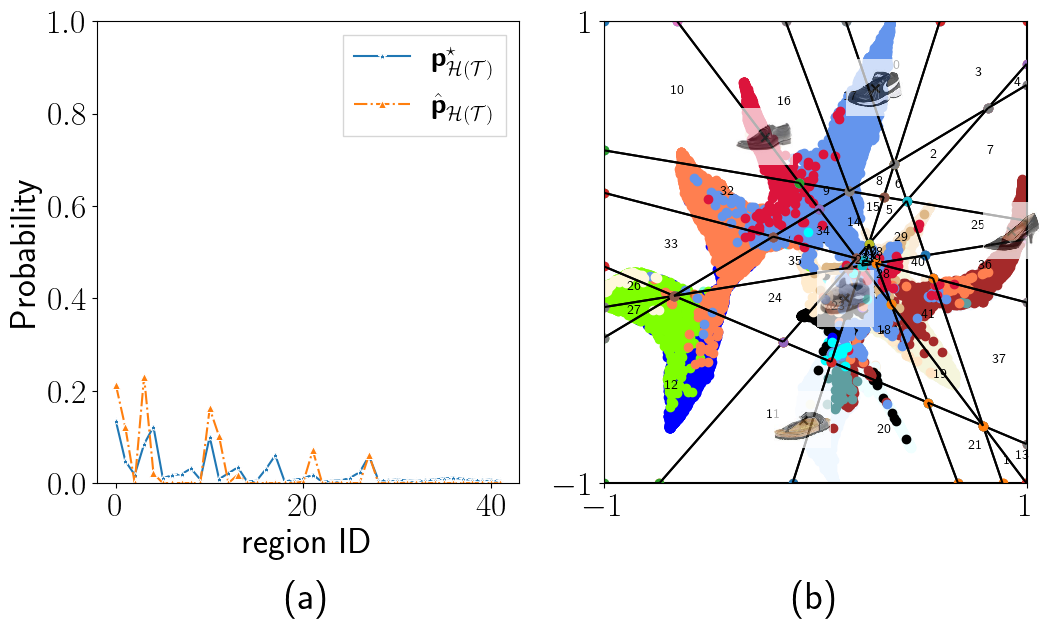

In [5]:
for i, (p_true, p_hat, _, _, _, _, _) in enumerate(results):

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})
    n_h = i + 1

    sns.lineplot(p_true, x="region ID", y="prob", ax=axs[0], label=PTRUE, marker="*", linestyle="-")
    sns.lineplot(p_hat, x="region ID", y="prob", ax=axs[0], err_style="bars", label=PHAT, marker="^", linestyle="-.")
    handles, labels = axs[0].get_legend_handles_labels()
    axs[0].legend(handles, labels, fancybox=False, shadow=False, fontsize=legend_size)
    axs[0].set_ylabel("Probability", fontsize=label_size)
    axs[0].set_xlabel("region ID", fontsize=label_size)
    axs[0].set_title(r"$n_h$ = " + f"{i + 1}", fontsize=title_size)
    axs[0].set_ylim([0, 1])
    if len(p_true) < 8:
        axs[0].set_xticks(np.arange(len(p_true)))
    axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
    axs[0].set_title("(" + f"{chr(97 + 0)}" + ")", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")


    plot_embedding(regions_s[i], axs[1], p_hat)
    axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
    axs[1].set_title("(" + f"{chr(97 + 1)}" + ")", loc="center", y=0, fontsize=title_size, pad=-70, verticalalignment="top")

    fig.savefig(f"fig/zappos_varying_n_h_{n_h}.pdf", dpi=300, format="pdf", bbox_inches='tight')
    fig.show()